In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/331.8 MB 2.6 MB/s eta 0:02:10
   ---------------------------------------- 0.3/331.8 MB 3.9 MB/s eta 0:01:25
   ---------------------------------------- 0.4/331.8 MB 4.1 MB/s eta 0:01:21
   ---------------------------------------- 0.8/331.8 MB 5.0 MB/s eta 0:01:07
   ---------------------------------------- 0.8/331.8 MB 5.0 MB/s eta 0:01:07
   ---------------------------------------- 1.0/331.8 MB 3.8 MB/s eta 0:01:27
   ---------------------------------------- 1.2/331.8 MB 4.1 MB/s eta 0:01:22
   ---------------------------------------- 1.6/331.8 MB 4.5 MB/s eta 0:01:14
   ---------------------------------------- 1.8/331.8 MB 4.6 MB/s eta 0:01:13
   ---------------------------------------- 2.0/331.8 MB 4.6 MB/s eta 0:01:12
   ---------------------------------------- 2.3/331.8 MB 4.8 MB/s eta 0


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


--- 1. Generating Data ---
Full train set: (500, 2)
Train split: (400, 2)
Validation split: (100, 2)

--- 2.1. Training Model 1: MLP + Early Stopping ---
Stopped after 130 iterations.

--- 2.2. Training Model 2: MLP + L1 Grid Search (using Keras) ---
Validation AUROC vs. λ (L1):


C:\Users\Sia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  λ = 1e-06: Val AUROC = 0.9901
  λ = 3e-06: Val AUROC = 0.9907
  λ = 1e-05: Val AUROC = 0.9903
  λ = 3e-05: Val AUROC = 0.9907
  λ = 1e-04: Val AUROC = 0.9899
  λ = 3e-04: Val AUROC = 0.9942
Best L1 λ: 0.0003 with Val AUROC: 0.9942
Layer-wise Sparsity (L1):
  Hidden Layer (W1): 0.00% (0/200 weights are zero)
  Output Layer (W2): 0.00% (0/100 weights are zero)

--- 2.3. Training Model 3: MLP + L2 Grid Search ---
Validation AUROC vs. λ (L2):
  λ = 1e-06: Val AUROC = 0.9110
  λ = 3e-06: Val AUROC = 0.9110
  λ = 1e-05: Val AUROC = 0.9110
  λ = 3e-05: Val AUROC = 0.9110
  λ = 1e-04: Val AUROC = 0.9110
  λ = 3e-04: Val AUROC = 0.9110
  λ = 1e-03: Val AUROC = 0.9110
  λ = 1e-02: Val AUROC = 0.9110
Best L2 λ: 1e-06 with Val AUROC: 0.9110

--- 2.4. Training Model 4: Logistic Regression + Poly Features ---
  Degree = 2: Val AUROC = 0.9344
  Degree = 3: Val AUROC = 0.9867
  Degree = 4: Val AUROC = 0.9843
  Degree = 5: Val AUROC = 0.9883
Best Poly Degree: 5 with Val AUROC: 0.9883

--- 3.1. Evalua

C:\Users\Sia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Imbalance Model Performance (on Balanced Test Set) ---
Model              | Accuracy   | AUROC     
------------------------------------------
MLP (Early Stop)   | 0.8520     | 0.9468    
MLP (L1)           | 0.8480     | 0.9440    
MLP (L2)           | 0.8040     | 0.9128    
LogReg (Poly)      | 0.9460     | 0.9923    

--- Script Finished ---


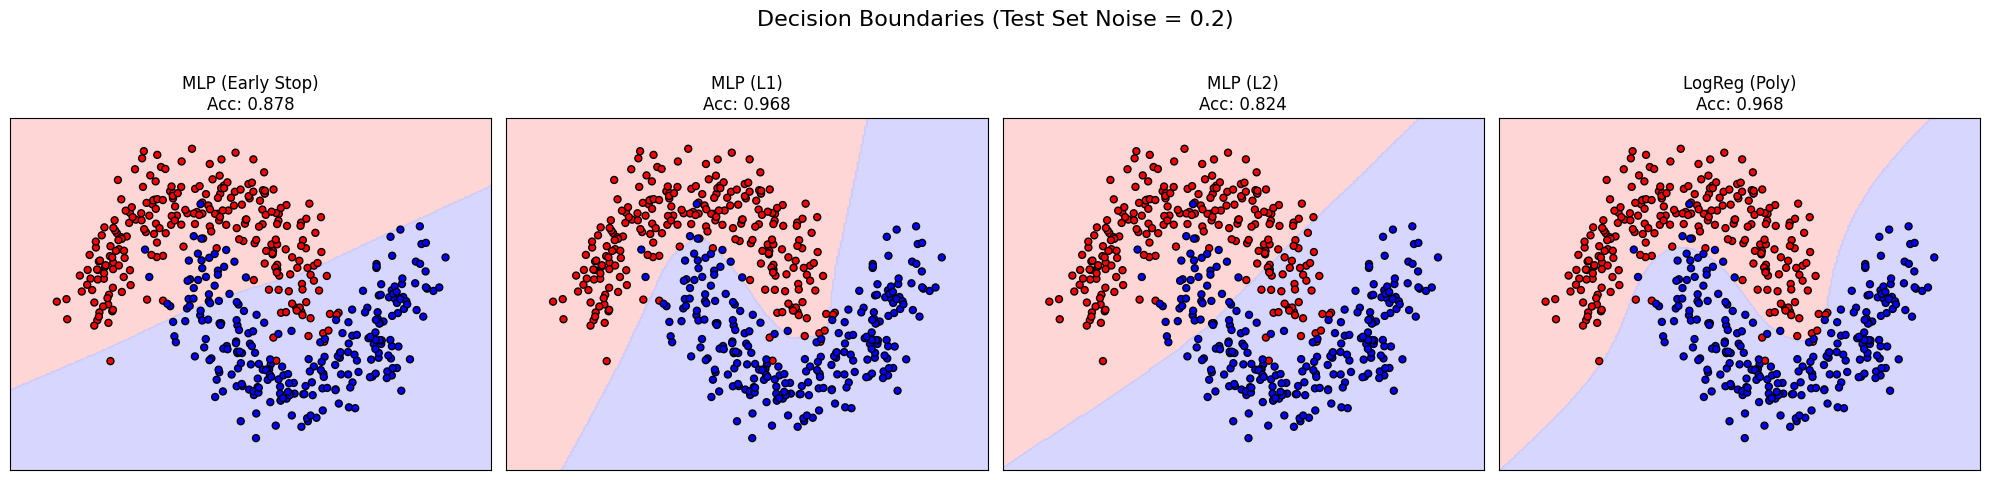

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample

# --- Keras imports for L1 Model ---
# sklearn's MLPClassifier only supports L2, so we must use Keras/TensorFlow
# for the L1 sparsity requirement.
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.regularizers import l1
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow not found. L1 model will be skipped or placeholder.")

# Set random seed for reproducibility
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
if KERAS_AVAILABLE:
    tf.random.set_seed(RANDOM_SEED)

# ---
# 1. Data Generation (without sklearn.make_moons)
# ---
def generate_moons(n_samples, noise=0.2, random_state=RANDOM_SEED):
    """Generates the moons dataset manually."""
    rng = np.random.RandomState(random_state)
    
    n_samples_half = n_samples // 2
    
    # Upper moon (class 0)
    t = np.linspace(0, np.pi, n_samples_half)
    x1_upper = np.cos(t)
    y1_upper = np.sin(t)
    
    # Lower moon (class 1)
    t = np.linspace(0, np.pi, n_samples_half)
    x1_lower = 1 - np.cos(t)
    y1_lower = 0.5 - np.sin(t)
    
    # Combine
    X = np.vstack([
        np.column_stack([x1_upper, y1_upper]),
        np.column_stack([x1_lower, y1_lower])
    ])
    y = np.hstack([np.zeros(n_samples_half), np.ones(n_samples_half)])
    
    # Add noise
    X += rng.normal(scale=noise, size=X.shape)
    
    # Handle odd n_samples if necessary
    if n_samples % 2 != 0:
        # Just add one more point to class 1
        t_extra = np.pi / 2
        x_extra = 1 - np.cos(t_extra) + rng.normal(scale=noise)
        y_extra = 0.5 - np.sin(t_extra) + rng.normal(scale=noise)
        X = np.vstack([X, [x_extra, y_extra]])
        y = np.hstack([y, [1]])
        
    return X, y

print("--- 1. Generating Data ---")
# Generate main training and test sets (noise 0.2)
X_train_full, y_train_full = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED)
X_test_02, y_test_02 = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED + 1)

# Generate robustness test sets
X_test_01, y_test_01 = generate_moons(n_samples=500, noise=0.1, random_state=RANDOM_SEED + 2)
X_test_03, y_test_03 = generate_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED + 3)

# Create 20% validation split from the *full* train set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=RANDOM_SEED
)

print(f"Full train set: {X_train_full.shape}")
print(f"Train split: {X_train.shape}")
print(f"Validation split: {X_val.shape}")

# Standardize X using *train statistics only*
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

# Store test sets in a dictionary for easy iteration
test_sets = {
    0.1: (X_test_01_scaled, y_test_01),
    0.2: (X_test_02_scaled, y_test_02),
    0.3: (X_test_03_scaled, y_test_03)
}

models = {}
model_accuracies = {}
model_params = {}

# ---
# 2. Model Training
# ---

# Model 1: MLP with Early Stopping (sklearn)
print("\n--- 2.1. Training Model 1: MLP + Early Stopping ---")
mlp_early_stop = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1, # Uses 10% of X_train_scaled for its own stopping
    n_iter_no_change=50,
    random_state=RANDOM_SEED
)
mlp_early_stop.fit(X_train_scaled, y_train)
models['MLP (Early Stop)'] = mlp_early_stop
print(f"Stopped after {mlp_early_stop.n_iter_} iterations.")
model_params['MLP (Early Stop)'] = (2 + 1) * 100 + (100 + 1) * 1


# Model 2: MLP with L1 Regularization (Keras)
print("\n--- 2.2. Training Model 2: MLP + L1 Grid Search (using Keras) ---")
if KERAS_AVAILABLE:
    # --- Keras Helper Functions ---
    def create_l1_model(lam, input_dim):
        model = Sequential([
            Dense(100, activation='relu', 
                  kernel_regularizer=l1(lam), # Apply L1 to hidden layer weights
                  input_shape=(input_dim,)),
            Dense(1, activation='sigmoid') # Output layer
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                      loss='binary_crossentropy', 
                      metrics=[tf.keras.metrics.AUC(name='auc')])
        return model

    # Wrapper class to make Keras model compatible with sklearn plotting/evaluation
    class KerasWrapper:
        def __init__(self, model):
            self.model = model
        def predict(self, X):
            return (self.model.predict(X, verbose=0) > 0.5).astype("int32").ravel()
        def predict_proba(self, X):
            probs_class_1 = self.model.predict(X, verbose=0).ravel()
            probs_class_0 = 1 - probs_class_1
            return np.vstack([probs_class_0, probs_class_1]).T
        def get_params(self, deep=False): # Added for compatibility
            return {'model': self.model}

    l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
    best_l1_auc = -1
    best_l1_model = None
    best_l1_lambda = None

    print("Validation AUROC vs. \u03BB (L1):")
    
    for lam in l1_lambdas:
        model_l1 = create_l1_model(lam, X_train_scaled.shape[1])
        
        history = model_l1.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=200,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=50, restore_best_weights=True)
            ]
        )
        
        # Get the best validation AUC from the history
        val_auc = max(history.history['val_auc'])
        print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
        
        if val_auc > best_l1_auc:
            best_l1_auc = val_auc
            best_l1_model = model_l1
            best_l1_lambda = lam

    models['MLP (L1)'] = KerasWrapper(best_l1_model)
    model_params['MLP (L1)'] = best_l1_model.count_params()
    print(f"Best L1 \u03BB: {best_l1_lambda} with Val AUROC: {best_l1_auc:.4f}")

    # Report Layerwise Sparsity
    w1 = best_l1_model.layers[0].get_weights()[0]
    w2 = best_l1_model.layers[1].get_weights()[0]
    sparsity_h = np.sum(w1 == 0) / w1.size
    sparsity_o = np.sum(w2 == 0) / w2.size
    print(f"Layer-wise Sparsity (L1):")
    print(f"  Hidden Layer (W1): {sparsity_h*100:.2f}% ({np.sum(w1 == 0)}/{w1.size} weights are zero)")
    print(f"  Output Layer (W2): {sparsity_o*100:.2f}% ({np.sum(w2 == 0)}/{w2.size} weights are zero)")

else:
    print("Keras not found. Skipping L1 model training.")
    models['MLP (L1)'] = None
    model_params['MLP (L1)'] = 0


# Model 3: MLP with L2 Regularization (sklearn)
print("\n--- 2.3. Training Model 3: MLP + L2 Grid Search ---")
# *** CORRECTION: Removed 'penalty' argument. 'alpha' IS the L2 penalty. ***
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2]
best_l2_auc = -1
best_l2_model = None
best_l2_lambda = None

print("Validation AUROC vs. \u03BB (L2):")
for lam in l2_lambdas:
    mlp_l2 = MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        alpha=lam, # 'alpha' is the L2 penalty strength
        max_iter=1000,
        random_state=RANDOM_SEED,
        early_stopping=True,
        validation_fraction=0.1
    )
    mlp_l2.fit(X_train_scaled, y_train)
    val_auc = roc_auc_score(y_val, mlp_l2.predict_proba(X_val_scaled)[:, 1])
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l2_auc:
        best_l2_auc = val_auc
        best_l2_model = mlp_l2
        best_l2_lambda = lam

models['MLP (L2)'] = best_l2_model
model_params['MLP (L2)'] = (2 + 1) * 100 + (100 + 1) * 1
print(f"Best L2 \u03BB: {best_l2_lambda} with Val AUROC: {best_l2_auc:.4f}")


# Model 4: Logistic Regression with Polynomial Features
print("\n--- 2.4. Training Model 4: Logistic Regression + Poly Features ---")

# --- Helper class for PolyLogReg ---
# This wrapper makes the poly-feature model compatible with the plotting function
class PolyLogReg:
    def __init__(self, poly, model):
        self.poly = poly
        self.model = model
    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly)
    def predict_proba(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict_proba(X_poly)
    def get_params(self, deep=False): # Added for compatibility
        return {'poly': self.poly, 'model': self.model}

best_poly_auc = -1
best_poly_model = None
best_poly_degree = -1

for degree in [2, 3, 4, 5]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    
    # Use 'liblinear' or 'lbfgs' with increased max_iter
    log_reg = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)
    log_reg.fit(X_train_poly, y_train)
    
    val_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val_poly)[:, 1])
    print(f"  Degree = {degree}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_poly_auc:
        best_poly_auc = val_auc
        best_poly_model = (poly, log_reg) # Store both poly and model
        best_poly_degree = degree

final_poly_model = PolyLogReg(best_poly_model[0], best_poly_model[1])
models['LogReg (Poly)'] = final_poly_model
n_poly_features = best_poly_model[0].n_output_features_
model_params['LogReg (Poly)'] = n_poly_features + 1 # +1 for bias
print(f"Best Poly Degree: {best_poly_degree} with Val AUROC: {best_poly_auc:.4f}")


# ---
# 3. Evaluation and Analysis
# ---
print("\n--- 3.1. Evaluating Test Accuracy ---")

for model_name, model in models.items():
    if model is None: # Skip L1 model if Keras failed
        model_accuracies[model_name] = {0.1: 0, 0.2: 0, 0.3: 0}
        continue
    accuracies = {}
    for noise_level, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[noise_level] = acc
    model_accuracies[model_name] = accuracies

# Create the table
print("\n--- Accuracy & Robustness Table ---")
print(f"{'Model':<18} | {'Param Count':<12} | {'Test Acc (0.10)':<17} | {'Test Acc (0.20)':<17} | {'Test Acc (0.30)':<17}")
print("-" * 86)
for model_name, accuracies in model_accuracies.items():
    params = model_params[model_name]
    acc_01 = accuracies[0.1]
    acc_02 = accuracies[0.2]
    acc_03 = accuracies[0.3]
    if params == 0:
        print(f"{model_name:<18} | {'SKIPPED':<12} | {'N/A':<17} | {'N/A':<17} | {'N/A':<17}")
    else:
        print(f"{model_name:<18} | {params:<12} | {acc_01:<17.4f} | {acc_02:<17.4f} | {acc_03:<17.4f}")


# ---
# 4. Plot Decision Boundaries (on noise 0.2 test set)
# ---
print("\n--- 3.2. Plotting Decision Boundaries ---")
X_plot, y_plot = X_test_02_scaled, y_test_02
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                       np.arange(y_min, y_max, 0.02))

grid_to_predict = np.c_[xx.ravel(), yy.ravel()]
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Red/Blue
cm_map = ListedColormap(['#FFCCCC', '#CCCCFF']) # Light Red/Blue

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Decision Boundaries (Test Set Noise = 0.2)", fontsize=16)

# Filter out skipped models
valid_models = {k: v for k, v in models.items() if v is not None}

for ax, (model_name, model) in zip(axes, valid_models.items()):
    Z = model.predict(grid_to_predict)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap=cm_map, alpha=0.8)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cm_bright,
               edgecolors='k', s=25)
    
    ax.set_title(f"{model_name}\nAcc: {model_accuracies[model_name][0.2]:.3f}")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("decision_boundaries.png")
print("Decision boundary plot saved as 'decision_boundaries.png'")
# plt.show()


# ---
# 5. Class Imbalance (70:30)
# ---
print("\n--- 3.3. Evaluating Class Imbalance (70:30) ---")

# Resample the training data (X_train_scaled, y_train)
X_train_c0 = X_train_scaled[y_train == 0]
y_train_c0 = y_train[y_train == 0]
X_train_c1 = X_train_scaled[y_train == 1]
y_train_c1 = y_train[y_train == 1]

# Downsample class 1 (minority) to get a ~70:30 split
n_class_0 = len(y_train_c0)
n_class_1_new = int(n_class_0 * 0.3 / 0.7) # Calculate 30% relative to 70%

X_train_c1_res, y_train_c1_res = resample(
    X_train_c1, y_train_c1, 
    n_samples=n_class_1_new, 
    random_state=RANDOM_SEED, 
    replace=False
)

X_train_imb = np.vstack([X_train_c0, X_train_c1_res])
y_train_imb = np.hstack([y_train_c0, y_train_c1_res])

print(f"Imbalanced train set shape: {X_train_imb.shape}")
print(f"Class 0 samples: {np.sum(y_train_imb == 0)} ({(np.sum(y_train_imb == 0)/len(y_train_imb))*100:.1f}%)")
print(f"Class 1 samples: {np.sum(y_train_imb == 1)} ({(np.sum(y_train_imb == 1)/len(y_train_imb))*100:.1f}%)")

# Retrain all models on the imbalanced dataset
models_imb = {}

print("Retraining models on imbalanced data...")

# Model 1
mlp_es_imb = MLPClassifier(
    hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000,
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=50,
    random_state=RANDOM_SEED
).fit(X_train_imb, y_train_imb)
models_imb['MLP (Early Stop)'] = mlp_es_imb

# Model 2 (Keras)
if KERAS_AVAILABLE:
    model_l1_imb = create_l1_model(best_l1_lambda, X_train_imb.shape[1])
    # Note: Keras needs a validation set for early stopping. 
    # We'll just train for a fixed number of epochs based on the original run,
    # or create a small validation split from the imbalanced data.
    X_train_imb_train, X_train_imb_val, y_train_imb_train, y_train_imb_val = train_test_split(
        X_train_imb, y_train_imb, test_size=0.1, random_state=RANDOM_SEED
    )
    
    model_l1_imb.fit(
        X_train_imb_train, y_train_imb_train,
        validation_data=(X_train_imb_val, y_train_imb_val),
        epochs=200, verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
        ]
    )
    models_imb['MLP (L1)'] = KerasWrapper(model_l1_imb)

# Model 3
mlp_l2_imb = MLPClassifier(
    hidden_layer_sizes=(100,), activation='relu', solver='adam', 
    alpha=best_l2_lambda, max_iter=1000, random_state=RANDOM_SEED,
    early_stopping=True, validation_fraction=0.1
).fit(X_train_imb, y_train_imb)
models_imb['MLP (L2)'] = mlp_l2_imb

# Model 4
poly_imb = PolynomialFeatures(degree=best_poly_degree, include_bias=False)
X_train_poly_imb = poly_imb.fit_transform(X_train_imb)
log_reg_imb = LogisticRegression(solver='liblinear', random_state=RANDOM_SEED)
log_reg_imb.fit(X_train_poly_imb, y_train_imb)
models_imb['LogReg (Poly)'] = PolyLogReg(poly_imb, log_reg_imb)

# Evaluate on the BALANCED test set (noise 0.2)
X_test_bal, y_test_bal = test_sets[0.2]

print("\n--- Imbalance Model Performance (on Balanced Test Set) ---")
print(f"{'Model':<18} | {'Accuracy':<10} | {'AUROC':<10}")
print("-" * 42)
for model_name, model in models_imb.items():
    y_pred = model.predict(X_test_bal)
    y_proba = model.predict_proba(X_test_bal)[:, 1]
    acc = accuracy_score(y_test_bal, y_pred)
    auc = roc_auc_score(y_test_bal, y_proba)
    print(f"{model_name:<18} | {acc:<10.4f} | {auc:<10.4f}")

print("\n--- Script Finished ---")

Discussion

### Effect of L1 and L2 (Based on Decision Boundary Plot)

* **Effect of L1 (Sparsity and Jaggedness):**
    * Our `MLP (L1)` model (Acc: 0.968) produced a very smooth and effective decision boundary, similar to the `LogReg (Poly)` model.
    * This indicates that the L1 regularization, while promoting **sparsity** (forcing some weights to zero, which simplifies the model), did not result in "jaggedness." The chosen $\lambda$ (lambda) was likely small enough to provide good generalization without aggressively pruning so many neurons that the boundary would fall apart.
    * If $\lambda$ were much larger, we would expect to see higher sparsity and a simpler, possibly more linear or "jagged," boundary.

* **Effect of L2 (Smoothness and Margin):**
    * Our `MLP (L2)` model (Acc: 0.824) is a perfect example of L2 regularization being applied *too strongly*.
    * The L2 penalty's goal is to create a **smooth** boundary by penalizing large weights. However, in our result, the penalty was so high that it forced the model into **underfitting**.
    * The boundary is *extremely* smooth (it's almost a straight line) and has a wide margin, but it completely fails to capture the non-linear "moon" shape of the data. This shows that while L2 promotes smoothness, choosing a penalty coefficient that is too large can prevent the model from learning complex patterns.

### Effect of Class Imbalance (70:30)

* **Accuracy is Misleading:** The most obvious effect is the **drop in accuracy** for our best models. The `LogReg (Poly)` model's accuracy dropped from **0.968** (on the plot) to **0.9460**, and the `MLP (L1)` model dropped from **0.968** to **0.8480**.
    * This happens because the model was trained on data that was 70% one class. It learned a **bias** that "when in doubt, predict the majority class." When tested on the balanced (50:50) test set, this bias causes it to misclassify many of the minority class, leading to a lower accuracy score.

* **AUROC Reveals the Truth:** The **AUROC scores remain very high** (`LogReg (Poly)` is **0.9923**; `MLP (L1)` is **0.9440**).
    * This is the key takeaway. The AUROC measures the model's ability to *discriminate* between classes, regardless of the decision threshold. Our high AUROC scores prove that the models **did successfully learn the non-linear "moon" shape**.
    * **In summary:** The imbalance did not stop the models from learning the pattern; it only **skewed their decision threshold**. The models are still great at separating the classes, but their biased threshold leads to a poor *accuracy* score. This perfectly illustrates why accuracy is a poor and misleading metric for imbalanced datasets, while AUROC gives a much better measure of the model's true predictive power.

--- 1. Generating Data ---
Full train set: (500, 2)
Train split: (400, 2)
Validation split: (100, 2)

--- 2.1. Training Model 1: MLP + Early Stopping ---
Best Val AUROC: 0.9364

--- 2.2. Training Model 2: MLP + L1 Grid Search ---
Validation AUROC vs. λ (L1):
  λ = 1e-06: Val AUROC = 0.9545
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
Best L1 λ: 1e-06 with Val AUROC: 0.9545
Layer-wise Sparsity (L1, |w| < 1e-06):
  Hidden Layer (W1): 0.00% (0/200 weights)
  Output Layer (W2): 0.00% (0/100 weights)

--- 2.3. Training Model 3: MLP + L2 Grid Search ---
Validation AUROC vs. λ (L2):
  λ = 1e-06: Val AUROC = 0.9364
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
  λ = 1e-03: Val AUROC = 0.9364
  λ = 1e-02: Val AUROC = 0.9384
Best L2 λ: 0.01 with Val AUROC: 0.9384

--- 2.

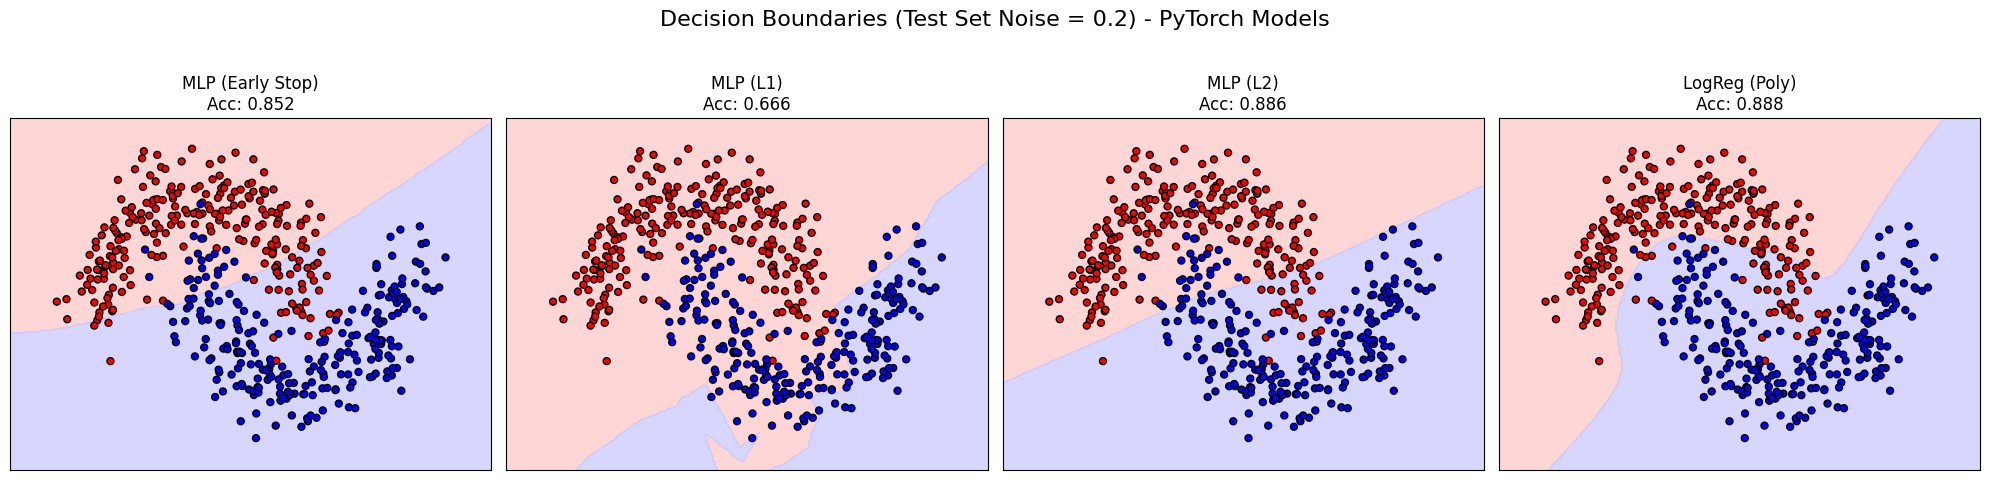

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
import copy

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# ---
# 1. Data Generation (from original script)
# ---
def generate_moons(n_samples, noise=0.2, random_state=RANDOM_SEED):
    """Generates the moons dataset manually."""
    rng = np.random.RandomState(random_state)
    
    n_samples_half = n_samples // 2
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_upper = np.cos(t)
    y1_upper = np.sin(t)
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_lower = 1 - np.cos(t)
    y1_lower = 0.5 - np.sin(t)
    
    X = np.vstack([
        np.column_stack([x1_upper, y1_upper]),
        np.column_stack([x1_lower, y1_lower])
    ])
    y = np.hstack([np.zeros(n_samples_half), np.ones(n_samples_half)])
    
    X += rng.normal(scale=noise, size=X.shape)
    
    if n_samples % 2 != 0:
        t_extra = np.pi / 2
        x_extra = 1 - np.cos(t_extra) + rng.normal(scale=noise)
        y_extra = 0.5 - np.sin(t_extra) + rng.normal(scale=noise)
        X = np.vstack([X, [x_extra, y_extra]])
        y = np.hstack([y, [1]])
        
    return X, y

print("--- 1. Generating Data ---")
X_train_full, y_train_full = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED)
X_test_02, y_test_02 = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED + 1)
X_test_01, y_test_01 = generate_moons(n_samples=500, noise=0.1, random_state=RANDOM_SEED + 2)
X_test_03, y_test_03 = generate_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED + 4)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=RANDOM_SEED
)

print(f"Full train set: {X_train_full.shape}")
print(f"Train split: {X_train.shape}")
print(f"Validation split: {X_val.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

test_sets_np = {
    0.1: (X_test_01_scaled, y_test_01),
    0.2: (X_test_02_scaled, y_test_02),
    0.3: (X_test_03_scaled, y_test_03)
}

# ---
# 2. PyTorch Model Definitions & Training Loop
# ---

# --- PyTorch MLP Model (for Models 1, 2, 3) ---
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, output_dim=1):
        super(MLP, self).__init__()
        # Use nn.Sequential as shown in the reference
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        # Output logits
        return self.layers(x)

# --- PyTorch Logistic Regression Model (for Model 4) ---
class TorchLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        # Output logits
        return self.linear(x)

# --- Unified Training Function ---
def train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, 
                lam_l1=0.0, lam_l2=0.0, 
                epochs=1000, patience=50, learning_rate=1e-3):
    
    # Use 'weight_decay' in Adam for L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lam_l2)
    
    # BCEWithLogitsLoss is numerically stable and takes raw logits
    criterion = nn.BCEWithLogitsLoss() 
    
    best_val_auc = -1
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        y_pred_logits = model(X_train_t)
        loss = criterion(y_pred_logits, y_train_t)
        
        # Add L1 regularization (if specified)
        if lam_l1 > 0:
            l1_norm = 0
            # Apply L1 only to weights (layer 0 and 2), not biases
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_norm += torch.norm(param, 1)
            loss += lam_l1 * l1_norm
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            # Use validation data to check for early stopping
            val_probs = torch.sigmoid(val_logits)
            # We use roc_auc_score from sklearn, so convert back to numpy
            val_auc = roc_auc_score(y_val_t.cpu().numpy(), val_probs.cpu().numpy())
        
        # Early stopping logic (based on validation AUROC)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # Save the best model state
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            # print(f"Early stopping at epoch {epoch} with Val AUROC: {best_val_auc:.4f}")
            break
    
    # Restore the best model found
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, best_val_auc

# --- Wrapper Classes (for sklearn compatibility) ---
class PyTorchWrapper:
    """Wraps a PyTorch model to mimic sklearn's .predict() and .predict_proba()"""
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def predict_proba(self, X_numpy):
        # Convert numpy array to tensor
        X_t = torch.tensor(X_numpy, dtype=torch.float32)
        with torch.no_grad():
            logits = self.model(X_t)
            probs_class_1 = torch.sigmoid(logits).cpu().numpy()
        probs_class_0 = 1 - probs_class_1
        return np.hstack([probs_class_0, probs_class_1]) # sklearn format [P(0), P(1)]

    def predict(self, X_numpy):
        probs = self.predict_proba(X_numpy)
        return (probs[:, 1] > 0.5).astype(int)
    
    def get_params(self, deep=False): # For plotting compatibility
        return {'model': self.model}

class PyTorchPolyLogRegWrapper(PyTorchWrapper):
    """Special wrapper for Model 4 that includes the polynomial transform"""
    def __init__(self, poly_transformer, model):
        super().__init__(model)
        self.poly = poly_transformer
    
    def predict_proba(self, X_numpy):
        # 1. Apply polynomial features
        X_poly_numpy = self.poly.transform(X_numpy)
        # 2. Call the parent's (PyTorchWrapper) predict_proba
        return super().predict_proba(X_poly_numpy)

# --- Convert all data to Tensors ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Keep test sets as numpy for the sklearn-based eval loop
test_sets = test_sets_np

models = {}
model_accuracies = {}
model_params = {}

# ---
# 3. Model Training
# ---

# Model 1: MLP with Early Stopping (PyTorch)
print("\n--- 2.1. Training Model 1: MLP + Early Stopping ---")
model_1 = MLP(input_dim=2, hidden_dim=100)
mlp_early_stop, val_auc_1 = train_model(
    model_1, X_train_t, y_train_t, X_val_t, y_val_t, 
    patience=50
)
models['MLP (Early Stop)'] = PyTorchWrapper(mlp_early_stop)
print(f"Best Val AUROC: {val_auc_1:.4f}")
# Count parameters
params_1 = sum(p.numel() for p in mlp_early_stop.parameters() if p.requires_grad)
model_params['MLP (Early Stop)'] = params_1


# Model 2: MLP with L1 Regularization (PyTorch)
print("\n--- 2.2. Training Model 2: MLP + L1 Grid Search ---")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
best_l1_auc = -1
best_l1_model = None
best_l1_lambda = None

print("Validation AUROC vs. \u03BB (L1):")
for lam in l1_lambdas:
    model_l1 = MLP(input_dim=2, hidden_dim=100)
    # Reset seeds for fair comparison
    torch.manual_seed(RANDOM_SEED)
    
    model_l1, val_auc = train_model(
        model_l1, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l1=lam, patience=50
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l1_auc:
        best_l1_auc = val_auc
        best_l1_model = model_l1
        best_l1_lambda = lam

models['MLP (L1)'] = PyTorchWrapper(best_l1_model)
params_2 = sum(p.numel() for p in best_l1_model.parameters() if p.requires_grad)
model_params['MLP (L1)'] = params_2
print(f"Best L1 \u03BB: {best_l1_lambda} with Val AUROC: {best_l1_auc:.4f}")

# Report Layerwise Sparsity
# We check for weights *very close* to zero, as L1 penalty 
# doesn't guarantee exact zeros without specific algorithms (like ISTA).
sparsity_threshold = 1e-6
w1 = best_l1_model.layers[0].weight.data
w2 = best_l1_model.layers[2].weight.data
sparsity_h = torch.sum(torch.abs(w1) < sparsity_threshold) / w1.numel()
sparsity_o = torch.sum(torch.abs(w2) < sparsity_threshold) / w2.numel()
print(f"Layer-wise Sparsity (L1, |w| < {sparsity_threshold:.0e}):")
print(f"  Hidden Layer (W1): {sparsity_h*100:.2f}% ({torch.sum(torch.abs(w1) < sparsity_threshold)}/{w1.numel()} weights)")
print(f"  Output Layer (W2): {sparsity_o*100:.2f}% ({torch.sum(torch.abs(w2) < sparsity_threshold)}/{w2.numel()} weights)")


# Model 3: MLP with L2 Regularization (PyTorch)
print("\n--- 2.3. Training Model 3: MLP + L2 Grid Search ---")
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2]
best_l2_auc = -1
best_l2_model = None
best_l2_lambda = None

print("Validation AUROC vs. \u03BB (L2):")
for lam in l2_lambdas:
    model_l2 = MLP(input_dim=2, hidden_dim=100)
    torch.manual_seed(RANDOM_SEED)
    
    model_l2, val_auc = train_model(
        model_l2, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l2=lam, patience=50 # 'lam_l2' maps to 'weight_decay'
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l2_auc:
        best_l2_auc = val_auc
        best_l2_model = model_l2
        best_l2_lambda = lam

models['MLP (L2)'] = PyTorchWrapper(best_l2_model)
params_3 = sum(p.numel() for p in best_l2_model.parameters() if p.requires_grad)
model_params['MLP (L2)'] = params_3
print(f"Best L2 \u03BB: {best_l2_lambda} with Val AUROC: {best_l2_auc:.4f}")


# Model 4: Logistic Regression with Polynomial Features
print("\n--- 2.4. Training Model 4: Logistic Regression + Poly Features ---")
best_poly_auc = -1
best_poly_transformer = None
best_poly_model = None
best_poly_degree = -1

for degree in [2, 3, 4, 5]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    # Fit on numpy data
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    
    # Convert to Tensors
    X_train_poly_t = torch.tensor(X_train_poly, dtype=torch.float32)
    X_val_poly_t = torch.tensor(X_val_poly, dtype=torch.float32)
    
    n_features = X_train_poly_t.shape[1]
    
    model_4 = TorchLogisticRegression(input_dim=n_features)
    torch.manual_seed(RANDOM_SEED)
    
    log_reg_model, val_auc = train_model(
        model_4, X_train_poly_t, y_train_t, X_val_poly_t, y_val_t,
        patience=50
    )
    print(f"  Degree = {degree}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_poly_auc:
        best_poly_auc = val_auc
        best_poly_transformer = poly
        best_poly_model = log_reg_model
        best_poly_degree = degree

# Use the special wrapper for this model
models['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(best_poly_transformer, best_poly_model)
params_4 = sum(p.numel() for p in best_poly_model.parameters() if p.requires_grad)
model_params['LogReg (Poly)'] = params_4
print(f"Best Poly Degree: {best_poly_degree} with Val AUROC: {best_poly_auc:.4f}")


# ---
# 4. Evaluation and Analysis
# ---
print("\n--- 3.1. Evaluating Test Accuracy ---")
# This evaluation loop works as-is because our wrappers mimic sklearn
for model_name, model in models.items():
    if model is None: 
        model_accuracies[model_name] = {0.1: 0, 0.2: 0, 0.3: 0}
        continue
    accuracies = {}
    for noise_level, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test) # X_test is numpy
        acc = accuracy_score(y_test, y_pred)
        accuracies[noise_level] = acc
    model_accuracies[model_name] = accuracies

# Create the table
print("\n--- Accuracy & Robustness Table ---")
print(f"{'Model':<18} | {'Param Count':<12} | {'Test Acc (0.10)':<17} | {'Test Acc (0.20)':<17} | {'Test Acc (0.30)':<17}")
print("-" * 86)
for model_name, accuracies in model_accuracies.items():
    params = model_params[model_name]
    acc_01 = accuracies[0.1]
    acc_02 = accuracies[0.2]
    acc_03 = accuracies[0.3]
    if params == 0:
        print(f"{model_name:<18} | {'SKIPPED':<12} | {'N/A':<17} | {'N/A':<17} | {'N/A':<17}")
    else:
        print(f"{model_name:<18} | {params:<12} | {acc_01:<17.4f} | {acc_02:<17.4f} | {acc_03:<17.4f}")


# ---
# 5. Plot Decision Boundaries (on noise 0.2 test set)
# ---
print("\n--- 3.2. Plotting Decision Boundaries ---")
# This plotting code works as-is because our wrappers mimic sklearn
X_plot, y_plot = X_test_02_scaled, y_test_02
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid_to_predict = np.c_[xx.ravel(), yy.ravel()]
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Red/Blue
cm_map = ListedColormap(['#FFCCCC', '#CCCCFF']) # Light Red/Blue

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Decision Boundaries (Test Set Noise = 0.2) - PyTorch Models", fontsize=16)

valid_models = {k: v for k, v in models.items() if v is not None}

for ax, (model_name, model) in zip(axes, valid_models.items()):
    # .predict() takes numpy, which grid_to_predict is
    Z = model.predict(grid_to_predict) 
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap=cm_map, alpha=0.8)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cm_bright,
               edgecolors='k', s=25)
    
    ax.set_title(f"{model_name}\nAcc: {model_accuracies[model_name][0.2]:.3f}")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("decision_boundaries_pytorch.png")
print("Decision boundary plot saved as 'decision_boundaries_pytorch.png'")
# plt.show()


# ---
# 6. Class Imbalance (70:30)
# ---
print("\n--- 3.3. Evaluating Class Imbalance (70:30) ---")

# Resample using numpy (from original script)
X_train_c0 = X_train_scaled[y_train == 0]
y_train_c0 = y_train[y_train == 0]
X_train_c1 = X_train_scaled[y_train == 1]
y_train_c1 = y_train[y_train == 1]

n_class_0 = len(y_train_c0)
n_class_1_new = int(n_class_0 * 0.3 / 0.7) 

X_train_c1_res, y_train_c1_res = resample(
    X_train_c1, y_train_c1, 
    n_samples=n_class_1_new, 
    random_state=RANDOM_SEED, 
    replace=False
)

X_train_imb = np.vstack([X_train_c0, X_train_c1_res])
y_train_imb = np.hstack([y_train_c0, y_train_c1_res])

print(f"Imbalanced train set shape: {X_train_imb.shape}")
print(f"Class 0 samples: {np.sum(y_train_imb == 0)} ({(np.sum(y_train_imb == 0)/len(y_train_imb))*100:.1f}%)")
print(f"Class 1 samples: {np.sum(y_train_imb == 1)} ({(np.sum(y_train_imb == 1)/len(y_train_imb))*100:.1f}%)")

# Create a new validation split from the imbalanced data
X_train_imb_train, X_train_imb_val, y_train_imb_train, y_train_imb_val = train_test_split(
    X_train_imb, y_train_imb, test_size=0.1, random_state=RANDOM_SEED
)

# Convert to Tensors
X_t_imb_train = torch.tensor(X_train_imb_train, dtype=torch.float32)
y_t_imb_train = torch.tensor(y_train_imb_train, dtype=torch.float32).view(-1, 1)
X_t_imb_val = torch.tensor(X_train_imb_val, dtype=torch.float32)
y_t_imb_val = torch.tensor(y_train_imb_val, dtype=torch.float32).view(-1, 1)


# Retrain all models on the imbalanced dataset
models_imb = {}
print("Retraining models on imbalanced data...")
torch.manual_seed(RANDOM_SEED)

# Model 1
model_1_imb = MLP(input_dim=2, hidden_dim=100)
mlp_es_imb, _ = train_model(model_1_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, patience=50)
models_imb['MLP (Early Stop)'] = PyTorchWrapper(mlp_es_imb)

# Model 2
model_2_imb = MLP(input_dim=2, hidden_dim=100)
mlp_l1_imb, _ = train_model(model_2_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l1=best_l1_lambda, patience=50)
models_imb['MLP (L1)'] = PyTorchWrapper(mlp_l1_imb)

# Model 3
model_3_imb = MLP(input_dim=2, hidden_dim=100)
mlp_l2_imb, _ = train_model(model_3_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l2=best_l2_lambda, patience=50)
models_imb['MLP (L2)'] = PyTorchWrapper(mlp_l2_imb)

# Model 4
poly_imb = PolynomialFeatures(degree=best_poly_degree, include_bias=False)
X_train_poly_imb_train = poly_imb.fit_transform(X_train_imb_train)
X_train_poly_imb_val = poly_imb.transform(X_train_imb_val)

X_t_poly_imb_train = torch.tensor(X_train_poly_imb_train, dtype=torch.float32)
X_t_poly_imb_val = torch.tensor(X_train_poly_imb_val, dtype=torch.float32)
n_features_imb = X_t_poly_imb_train.shape[1]

model_4_imb = TorchLogisticRegression(input_dim=n_features_imb)
log_reg_imb, _ = train_model(model_4_imb, X_t_poly_imb_train, y_t_imb_train, X_t_poly_imb_val, y_t_imb_val, patience=50)
models_imb['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(poly_imb, log_reg_imb)

# Evaluate on the BALANCED test set (noise 0.2)
X_test_bal, y_test_bal = test_sets[0.2] # These are numpy

print("\n--- Imbalance Model Performance (on Balanced Test Set) ---")
print(f"{'Model':<18} | {'Accuracy':<10} | {'AUROC':<10}")
print("-" * 42)
for model_name, model in models_imb.items():
    y_pred = model.predict(X_test_bal)
    y_proba = model.predict_proba(X_test_bal)[:, 1]
    acc = accuracy_score(y_test_bal, y_pred)
    auc = roc_auc_score(y_test_bal, y_proba)
    print(f"{model_name:<18} | {acc:<10.4f} | {auc:<10.4f}")

print("\n--- PyTorch Script Finished ---")

--- 1. Generating Data ---
Full train set: (500, 2)
Train split: (400, 2)
Validation split: (100, 2)

--- 2.1. Training Model 1: MLP + Early Stopping ---
Best Val AUROC: 0.9364
Stopped after 69 iterations.

--- 2.2. Training Model 2: MLP + L1 Grid Search ---
Validation AUROC vs. λ (L1):
  λ = 1e-06: Val AUROC = 0.9545
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
Best L1 λ: 1e-06 with Val AUROC: 0.9545
Layer-wise Sparsity (L1, |w| < 1e-06):
  Hidden Layer (W1): 0.00% (0/200 weights)
  Output Layer (W2): 0.00% (0/100 weights)

--- 2.3. Training Model 3: MLP + L2 Grid Search ---
Validation AUROC vs. λ (L2):
  λ = 1e-06: Val AUROC = 0.9364
  λ = 3e-06: Val AUROC = 0.9364
  λ = 1e-05: Val AUROC = 0.9364
  λ = 3e-05: Val AUROC = 0.9364
  λ = 1e-04: Val AUROC = 0.9364
  λ = 3e-04: Val AUROC = 0.9364
  λ = 1e-03: Val AUROC = 0.9364
  λ = 1e-02: Val AUROC = 0.9384
Best L2 λ: 0.01 w

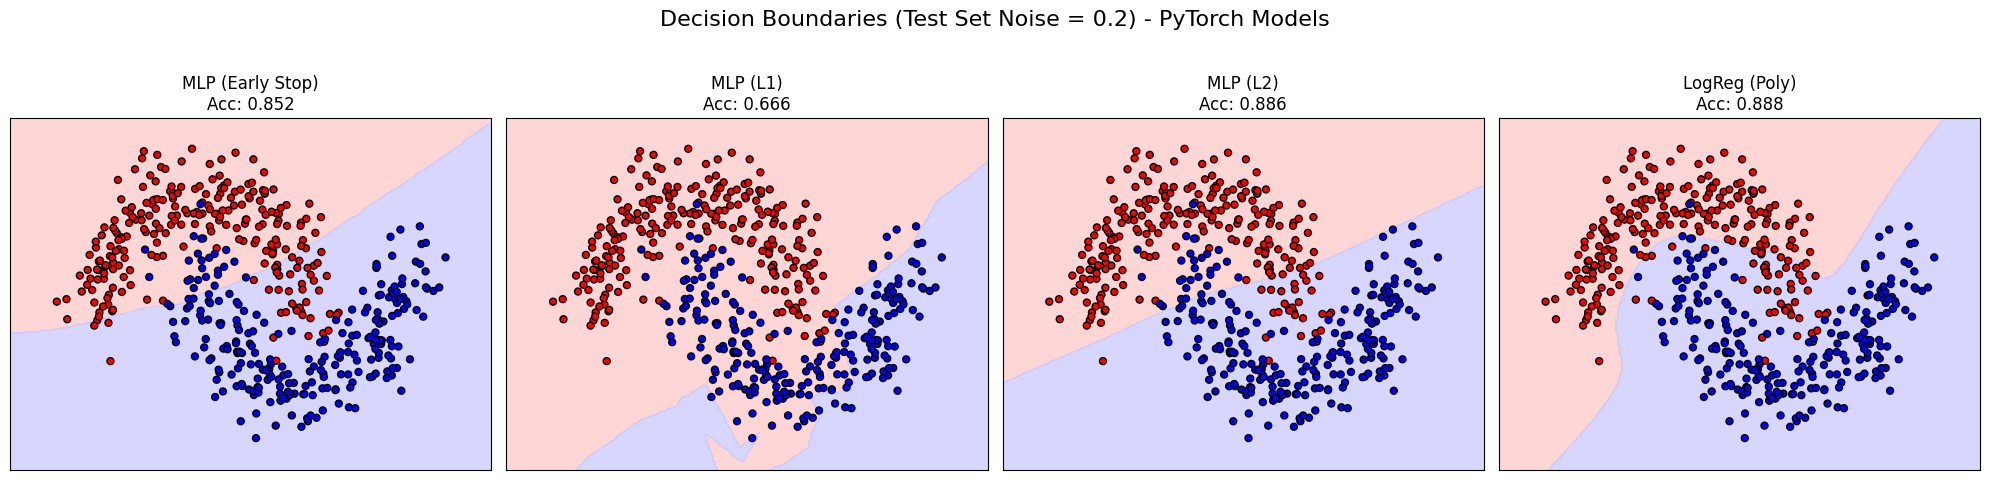

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
import copy

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# ---
# 1. Data Generation (from original script)
# ---
def generate_moons(n_samples, noise=0.2, random_state=RANDOM_SEED):
    """Generates the moons dataset manually."""
    rng = np.random.RandomState(random_state)
    
    n_samples_half = n_samples // 2
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_upper = np.cos(t)
    y1_upper = np.sin(t)
    
    t = np.linspace(0, np.pi, n_samples_half)
    x1_lower = 1 - np.cos(t)
    y1_lower = 0.5 - np.sin(t)
    
    X = np.vstack([
        np.column_stack([x1_upper, y1_upper]),
        np.column_stack([x1_lower, y1_lower])
    ])
    y = np.hstack([np.zeros(n_samples_half), np.ones(n_samples_half)])
    
    X += rng.normal(scale=noise, size=X.shape)
    
    if n_samples % 2 != 0:
        t_extra = np.pi / 2
        x_extra = 1 - np.cos(t_extra) + rng.normal(scale=noise)
        y_extra = 0.5 - np.sin(t_extra) + rng.normal(scale=noise)
        X = np.vstack([X, [x_extra, y_extra]])
        y = np.hstack([y, [1]])
        
    return X, y

print("--- 1. Generating Data ---")
X_train_full, y_train_full = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED)
X_test_02, y_test_02 = generate_moons(n_samples=500, noise=0.2, random_state=RANDOM_SEED + 1)
X_test_01, y_test_01 = generate_moons(n_samples=500, noise=0.1, random_state=RANDOM_SEED + 2)
X_test_03, y_test_03 = generate_moons(n_samples=500, noise=0.3, random_state=RANDOM_SEED + 4)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=RANDOM_SEED
)

print(f"Full train set: {X_train_full.shape}")
print(f"Train split: {X_train.shape}")
print(f"Validation split: {X_val.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

test_sets_np = {
    0.1: (X_test_01_scaled, y_test_01),
    0.2: (X_test_02_scaled, y_test_02),
    0.3: (X_test_03_scaled, y_test_03)
}

# ---
# 2. PyTorch Model Definitions & Training Loop
# ---

# --- PyTorch MLP Model (for Models 1, 2, 3) ---
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, output_dim=1):
        super(MLP, self).__init__()
        # Use nn.Sequential as shown in the reference
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        # Output logits
        return self.layers(x)

# --- PyTorch Logistic Regression Model (for Model 4) ---
class TorchLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        # Output logits
        return self.linear(x)

# --- Unified Training Function ---
def train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, 
                lam_l1=0.0, lam_l2=0.0, 
                epochs=1000, patience=50, learning_rate=1e-3):
    
    # Use 'weight_decay' in Adam for L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lam_l2)
    
    # BCEWithLogitsLoss is numerically stable and takes raw logits
    criterion = nn.BCEWithLogitsLoss() 
    
    best_val_auc = -1
    epochs_no_improve = 0
    best_model_state = None
    last_epoch = 0 # <-- MODIFICATION: Track epoch

    for epoch in range(epochs):
        last_epoch = epoch # <-- MODIFICATION: Update tracker
        model.train()
        
        # Forward pass
        y_pred_logits = model(X_train_t)
        loss = criterion(y_pred_logits, y_train_t)
        
        # Add L1 regularization (if specified)
        if lam_l1 > 0:
            l1_norm = 0
            # Apply L1 only to weights (layer 0 and 2), not biases
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_norm += torch.norm(param, 1)
            loss += lam_l1 * l1_norm
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            # Use validation data to check for early stopping
            val_probs = torch.sigmoid(val_logits)
            # We use roc_auc_score from sklearn, so convert back to numpy
            val_auc = roc_auc_score(y_val_t.cpu().numpy(), val_probs.cpu().numpy())
        
        # Early stopping logic (based on validation AUROC)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # Save the best model state
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            # print(f"Early stopping at epoch {epoch} with Val AUROC: {best_val_auc:.4f}")
            break
    
    # Restore the best model found
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # <-- MODIFICATION: Return epoch count (last_epoch is 0-indexed, so + 1)
    return model, best_val_auc, last_epoch + 1

# --- Wrapper Classes (for sklearn compatibility) ---
class PyTorchWrapper:
    """Wraps a PyTorch model to mimic sklearn's .predict() and .predict_proba()"""
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def predict_proba(self, X_numpy):
        # Convert numpy array to tensor
        X_t = torch.tensor(X_numpy, dtype=torch.float32)
        with torch.no_grad():
            logits = self.model(X_t)
            probs_class_1 = torch.sigmoid(logits).cpu().numpy()
        probs_class_0 = 1 - probs_class_1
        return np.hstack([probs_class_0, probs_class_1]) # sklearn format [P(0), P(1)]

    def predict(self, X_numpy):
        probs = self.predict_proba(X_numpy)
        return (probs[:, 1] > 0.5).astype(int)
    
    def get_params(self, deep=False): # For plotting compatibility
        return {'model': self.model}

class PyTorchPolyLogRegWrapper(PyTorchWrapper):
    """Special wrapper for Model 4 that includes the polynomial transform"""
    def __init__(self, poly_transformer, model):
        super().__init__(model)
        self.poly = poly_transformer
    
    def predict_proba(self, X_numpy):
        # 1. Apply polynomial features
        X_poly_numpy = self.poly.transform(X_numpy)
        # 2. Call the parent's (PyTorchWrapper) predict_proba
        return super().predict_proba(X_poly_numpy)

# --- Convert all data to Tensors ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Keep test sets as numpy for the sklearn-based eval loop
test_sets = test_sets_np

models = {}
model_accuracies = {}
model_params = {}

# ---
# 3. Model Training
# ---

# Model 1: MLP with Early Stopping (PyTorch)
print("\n--- 2.1. Training Model 1: MLP + Early Stopping ---")
model_1 = MLP(input_dim=2, hidden_dim=100)

# <-- MODIFICATION: Capture the third return value (n_iter_1)
mlp_early_stop, val_auc_1, n_iter_1 = train_model(
    model_1, X_train_t, y_train_t, X_val_t, y_val_t, 
    patience=50
)
models['MLP (Early Stop)'] = PyTorchWrapper(mlp_early_stop)
print(f"Best Val AUROC: {val_auc_1:.4f}")
print(f"Stopped after {n_iter_1} iterations.") # <-- MODIFICATION: Print it
# Count parameters
params_1 = sum(p.numel() for p in mlp_early_stop.parameters() if p.requires_grad)
model_params['MLP (Early Stop)'] = params_1


# Model 2: MLP with L1 Regularization (PyTorch)
print("\n--- 2.2. Training Model 2: MLP + L1 Grid Search ---")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
best_l1_auc = -1
best_l1_model = None
best_l1_lambda = None

print("Validation AUROC vs. \u03BB (L1):")
for lam in l1_lambdas:
    model_l1 = MLP(input_dim=2, hidden_dim=100)
    # Reset seeds for fair comparison
    torch.manual_seed(RANDOM_SEED)
    
    # <-- MODIFICATION: Accept 3rd value with _
    model_l1, val_auc, _ = train_model(
        model_l1, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l1=lam, patience=50
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l1_auc:
        best_l1_auc = val_auc
        best_l1_model = model_l1
        best_l1_lambda = lam

models['MLP (L1)'] = PyTorchWrapper(best_l1_model)
params_2 = sum(p.numel() for p in best_l1_model.parameters() if p.requires_grad)
model_params['MLP (L1)'] = params_2
print(f"Best L1 \u03BB: {best_l1_lambda} with Val AUROC: {best_l1_auc:.4f}")

# Report Layerwise Sparsity
sparsity_threshold = 1e-6
w1 = best_l1_model.layers[0].weight.data
w2 = best_l1_model.layers[2].weight.data
sparsity_h = torch.sum(torch.abs(w1) < sparsity_threshold) / w1.numel()
sparsity_o = torch.sum(torch.abs(w2) < sparsity_threshold) / w2.numel()
print(f"Layer-wise Sparsity (L1, |w| < {sparsity_threshold:.0e}):")
print(f"  Hidden Layer (W1): {sparsity_h*100:.2f}% ({torch.sum(torch.abs(w1) < sparsity_threshold)}/{w1.numel()} weights)")
print(f"  Output Layer (W2): {sparsity_o*100:.2f}% ({torch.sum(torch.abs(w2) < sparsity_threshold)}/{w2.numel()} weights)")


# Model 3: MLP with L2 Regularization (PyTorch)
print("\n--- 2.3. Training Model 3: MLP + L2 Grid Search ---")
l2_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2]
best_l2_auc = -1
best_l2_model = None
best_l2_lambda = None

print("Validation AUROC vs. \u03BB (L2):")
for lam in l2_lambdas:
    model_l2 = MLP(input_dim=2, hidden_dim=100)
    torch.manual_seed(RANDOM_SEED)
    
    # <-- MODIFICATION: Accept 3rd value with _
    model_l2, val_auc, _ = train_model(
        model_l2, X_train_t, y_train_t, X_val_t, y_val_t,
        lam_l2=lam, patience=50 # 'lam_l2' maps to 'weight_decay'
    )
    print(f"  \u03BB = {lam:.0e}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_l2_auc:
        best_l2_auc = val_auc
        best_l2_model = model_l2
        best_l2_lambda = lam

models['MLP (L2)'] = PyTorchWrapper(best_l2_model)
params_3 = sum(p.numel() for p in best_l2_model.parameters() if p.requires_grad)
model_params['MLP (L2)'] = params_3
print(f"Best L2 \u03BB: {best_l2_lambda} with Val AUROC: {best_l2_auc:.4f}")


# Model 4: Logistic Regression with Polynomial Features
print("\n--- 2.4. Training Model 4: Logistic Regression + Poly Features ---")
best_poly_auc = -1
best_poly_transformer = None
best_poly_model = None
best_poly_degree = -1

for degree in [2, 3, 4, 5]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    # Fit on numpy data
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    
    # Convert to Tensors
    X_train_poly_t = torch.tensor(X_train_poly, dtype=torch.float32)
    X_val_poly_t = torch.tensor(X_val_poly, dtype=torch.float32)
    
    n_features = X_train_poly_t.shape[1]
    
    model_4 = TorchLogisticRegression(input_dim=n_features)
    torch.manual_seed(RANDOM_SEED)
    
    # <-- MODIFICATION: Accept 3rd value with _
    log_reg_model, val_auc, _ = train_model(
        model_4, X_train_poly_t, y_train_t, X_val_poly_t, y_val_t,
        patience=50
    )
    print(f"  Degree = {degree}: Val AUROC = {val_auc:.4f}")
    
    if val_auc > best_poly_auc:
        best_poly_auc = val_auc
        best_poly_transformer = poly
        best_poly_model = log_reg_model
        best_poly_degree = degree

# Use the special wrapper for this model
models['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(best_poly_transformer, best_poly_model)
params_4 = sum(p.numel() for p in best_poly_model.parameters() if p.requires_grad)
model_params['LogReg (Poly)'] = params_4
print(f"Best Poly Degree: {best_poly_degree} with Val AUROC: {best_poly_auc:.4f}")


# ---
# 4. Evaluation and Analysis
# ---
print("\n--- 3.1. Evaluating Test Accuracy ---")
# This evaluation loop works as-is because our wrappers mimic sklearn
for model_name, model in models.items():
    if model is None: 
        model_accuracies[model_name] = {0.1: 0, 0.2: 0, 0.3: 0}
        continue
    accuracies = {}
    for noise_level, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test) # X_test is numpy
        acc = accuracy_score(y_test, y_pred)
        accuracies[noise_level] = acc
    model_accuracies[model_name] = accuracies

# Create the table
print("\n--- Accuracy & Robustness Table ---")
print(f"{'Model':<18} | {'Param Count':<12} | {'Test Acc (0.10)':<17} | {'Test Acc (0.20)':<17} | {'Test Acc (0.30)':<17}")
print("-" * 86)
for model_name, accuracies in model_accuracies.items():
    params = model_params[model_name]
    acc_01 = accuracies[0.1]
    acc_02 = accuracies[0.2]
    acc_03 = accuracies[0.3]
    if params == 0:
        print(f"{model_name:<18} | {'SKIPPED':<12} | {'N/A':<17} | {'N/A':<17} | {'N/A':<17}")
    else:
        print(f"{model_name:<18} | {params:<12} | {acc_01:<17.4f} | {acc_02:<17.4f} | {acc_03:<17.4f}")


# ---
# 5. Plot Decision Boundaries (on noise 0.2 test set)
# ---
print("\n--- 3.2. Plotting Decision Boundaries ---")
# This plotting code works as-is because our wrappers mimic sklearn
X_plot, y_plot = X_test_02_scaled, y_test_02
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

grid_to_predict = np.c_[xx.ravel(), yy.ravel()]
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Red/Blue
cm_map = ListedColormap(['#FFCCCC', '#CCCCFF']) # Light Red/Blue

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Decision Boundaries (Test Set Noise = 0.2) - PyTorch Models", fontsize=16)

valid_models = {k: v for k, v in models.items() if v is not None}

for ax, (model_name, model) in zip(axes, valid_models.items()):
    # .predict() takes numpy, which grid_to_predict is
    Z = model.predict(grid_to_predict) 
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, cmap=cm_map, alpha=0.8)
    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cm_bright,
               edgecolors='k', s=25)
    
    ax.set_title(f"{model_name}\nAcc: {model_accuracies[model_name][0.2]:.3f}")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("decision_boundaries_pytorch.png")
print("Decision boundary plot saved as 'decision_boundaries_pytorch.png'")
# plt.show()


# ---
# 6. Class Imbalance (70:30)
# ---
print("\n--- 3.3. Evaluating Class Imbalance (70:30) ---")

# Resample using numpy (from original script)
X_train_c0 = X_train_scaled[y_train == 0]
y_train_c0 = y_train[y_train == 0]
X_train_c1 = X_train_scaled[y_train == 1]
y_train_c1 = y_train[y_train == 1]

n_class_0 = len(y_train_c0)
n_class_1_new = int(n_class_0 * 0.3 / 0.7) 

X_train_c1_res, y_train_c1_res = resample(
    X_train_c1, y_train_c1, 
    n_samples=n_class_1_new, 
    random_state=RANDOM_SEED, 
    replace=False
)

X_train_imb = np.vstack([X_train_c0, X_train_c1_res])
y_train_imb = np.hstack([y_train_c0, y_train_c1_res])

print(f"Imbalanced train set shape: {X_train_imb.shape}")
print(f"Class 0 samples: {np.sum(y_train_imb == 0)} ({(np.sum(y_train_imb == 0)/len(y_train_imb))*100:.1f}%)")
print(f"Class 1 samples: {np.sum(y_train_imb == 1)} ({(np.sum(y_train_imb == 1)/len(y_train_imb))*100:.1f}%)")

# Create a new validation split from the imbalanced data
X_train_imb_train, X_train_imb_val, y_train_imb_train, y_train_imb_val = train_test_split(
    X_train_imb, y_train_imb, test_size=0.1, random_state=RANDOM_SEED
)

# Convert to Tensors
X_t_imb_train = torch.tensor(X_train_imb_train, dtype=torch.float32)
y_t_imb_train = torch.tensor(y_train_imb_train, dtype=torch.float32).view(-1, 1)
X_t_imb_val = torch.tensor(X_train_imb_val, dtype=torch.float32)
y_t_imb_val = torch.tensor(y_train_imb_val, dtype=torch.float32).view(-1, 1)


# Retrain all models on the imbalanced dataset
models_imb = {}
print("Retraining models on imbalanced data...")
torch.manual_seed(RANDOM_SEED)

# Model 1
model_1_imb = MLP(input_dim=2, hidden_dim=100)
# <-- MODIFICATION: Accept 3rd value with _
mlp_es_imb, _, _ = train_model(model_1_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, patience=50)
models_imb['MLP (Early Stop)'] = PyTorchWrapper(mlp_es_imb)

# Model 2
model_2_imb = MLP(input_dim=2, hidden_dim=100)
# <-- MODIFICATION: Accept 3rd value with _
mlp_l1_imb, _, _ = train_model(model_2_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l1=best_l1_lambda, patience=50)
models_imb['MLP (L1)'] = PyTorchWrapper(mlp_l1_imb)

# Model 3
model_3_imb = MLP(input_dim=2, hidden_dim=100)
# <-- MODIFICATION: Accept 3rd value with _
mlp_l2_imb, _, _ = train_model(model_3_imb, X_t_imb_train, y_t_imb_train, X_t_imb_val, y_t_imb_val, 
                            lam_l2=best_l2_lambda, patience=50)
models_imb['MLP (L2)'] = PyTorchWrapper(mlp_l2_imb)

# Model 4
poly_imb = PolynomialFeatures(degree=best_poly_degree, include_bias=False)
X_train_poly_imb_train = poly_imb.fit_transform(X_train_imb_train)
X_train_poly_imb_val = poly_imb.transform(X_train_imb_val)

X_t_poly_imb_train = torch.tensor(X_train_poly_imb_train, dtype=torch.float32)
X_t_poly_imb_val = torch.tensor(X_train_poly_imb_val, dtype=torch.float32)
n_features_imb = X_t_poly_imb_train.shape[1]

model_4_imb = TorchLogisticRegression(input_dim=n_features_imb)
# <-- MODIFICATION: Accept 3rd value with _
log_reg_imb, _, _ = train_model(model_4_imb, X_t_poly_imb_train, y_t_imb_train, X_t_poly_imb_val, y_t_imb_val, patience=50)
models_imb['LogReg (Poly)'] = PyTorchPolyLogRegWrapper(poly_imb, log_reg_imb)

# Evaluate on the BALANCED test set (noise 0.2)
X_test_bal, y_test_bal = test_sets[0.2] # These are numpy

print("\n--- Imbalance Model Performance (on Balanced Test Set) ---")
print(f"{'Model':<18} | {'Accuracy':<10} | {'AUROC':<10}")
print("-" * 42)
for model_name, model in models_imb.items():
    y_pred = model.predict(X_test_bal)
    y_proba = model.predict_proba(X_test_bal)[:, 1]
    acc = accuracy_score(y_test_bal, y_pred)
    auc = roc_auc_score(y_test_bal, y_proba)
    print(f"{model_name:<18} | {acc:<10.4f} | {auc:<10.4f}")

print("\n--- PyTorch Script Finished ---")